In [580]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

import geopandas as gpd
import shapely
from shapely.geometry import Point

import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

from descartes import PolygonPatch
import dill

In [285]:
# connecting to local database using psycopg2
try:
    conn_plocal = psycopg2.connect("dbname='nysRealEstate' user='enghuiy' host='localhost' password=''")
except:
    print "I am unable to connect to the database"

connl.set_session(autocommit=True);   
cur = connl.cursor()


# reference shapefile : elementary, secondary and unified school districts from census

In [527]:
#shapefile : census school district (note: NYC is considered one big bloc)

unsd_read = gpd.read_file('./Shapefiles/Census_schoolDistricts/tl_2015_36_unsd.shp').to_crs(epsg='4326')
#elsd_read = gpd.read_file('./Shapefiles/tl_2015_36_elsd.shp')
scsd_read = gpd.read_file('./Shapefiles/Census_schoolDistricts/tl_2015_36_scsd.shp').to_crs(epsg='4326')


In [454]:
scsd_read[0:3]
unsd_read[0:3]

,ALAND,AWATER,FUNCSTAT,GEOID,HIGRADE,INTPTLAT,INTPTLON,LOGRADE,LSAD,MTFCC,NAME,SDTYP,STATEFP,UNSDLEA,geometry
0,20841637.0,2810849.0,E,3626370,12,+40.8363406,-073.6240579,KG,00,G5420,North Shore Central School District,None,36,26370,"POLYGON ((-73.67107299999999 40.859299, -73.65..."
1,12238393.0,23284927.0,E,3626400,12,+40.5971567,-073.4894940,KG,00,G5420,Seaford Union Free School District,None,36,26400,"POLYGON ((-73.50683099999999 40.666806, -73.50..."
2,17190813.0,35783.0,E,3629280,12,+40.7148763,-073.5958961,KG,00,G5420,Uniondale Union Free School District,None,36,29280,"POLYGON ((-73.619737 40.68251799999999, -73.61..."


In [528]:
# 
sc_toAdd = scsd_read[scsd_read['NAME'].str.contains('Bellmore-Merrick|Sewanhaka|Valley Stream')][['NAME','GEOID','geometry']]
df_refSHP = unsd_read[['NAME','GEOID','geometry']].append(sc_toAdd)
#df_refSHP = unsd_read[['NAME','GEOID','geometry']]

# delete some data
#nysch=nysch[~nysch["NAME"].str.contains('School District Not Defined')]
#nysch=nysch[~nysch["NAME"].str.contains('Binghamton Common School District')]

df_refSHP['refshpindex'] = range(len(df_refSHP))
df_refSHP.set_index(['refshpindex'],inplace=True)
df_refSHP.rename(columns={'NAME':'name','GEOID':'geoid'},inplace=True)

In [529]:
refshape_json = []
for i in range(len(unsd_read)):
    refshape_json.append(unsd_read[i:i+1].to_json())
for i in range(len(scsd_read)):
    refshape_json.append(scsd_read[i:i+1].to_json())
df_refSHP['json']=refshape_json

In [530]:
# compute centroid
def getCentroid(shape):
    c=shape.centroid
    return (c.x,c.y)
df_refSHP['centroid'] = df_refSHP['geometry'].apply(lambda s: getCentroid(s))


In [531]:
df_refSHP[:4]

,name,geoid,geometry,json,centroid
refshpindex,,,,,
0,North Shore Central School District,3626370,"POLYGON ((-73.67107299999999 40.859299, -73.65...","{""type"": ""FeatureCollection"", ""features"": [{""g...","(-73.6239251152, 40.8362893218)"
1,Seaford Union Free School District,3626400,"POLYGON ((-73.50683099999999 40.666806, -73.50...","{""type"": ""FeatureCollection"", ""features"": [{""g...","(-73.4887751411, 40.5975612621)"
2,Uniondale Union Free School District,3629280,"POLYGON ((-73.619737 40.68251799999999, -73.61...","{""type"": ""FeatureCollection"", ""features"": [{""g...","(-73.5972693079, 40.7139621285)"
3,Wantagh Union Free School District,3629850,"POLYGON ((-73.52614799999999 40.691816, -73.52...","{""type"": ""FeatureCollection"", ""features"": [{""g...","(-73.5076679901, 40.6195001311)"


In [532]:
# add county info
countyshape_read= gpd.read_file('./Shapefiles/NYS_GIS_civil/Counties.shp').to_crs(epsg='4326')
df_countyshape = countyshape_read[['NAME','geometry']]

In [525]:
countyshape_read[:3]

,ABBREV,CALC_SqMi,COUNTYFIPS,DATEMOD,DOSLL_DATE,DOS_LL,GNIS_ID,NAME,NYC,POP1990,POP2000,POP2010,SP_ZONE,SWIS,geometry
0,ALBA,532.886898,001,None,None,None,974099,Albany,N,292594,294565,304204,East,010000,POLYGON ((-73.70877452249233 42.78724306639314...
1,ALLE,1035.237103,003,None,None,None,974100,Allegany,N,50470,49927,48946,West,020000,POLYGON ((-78.29217504218194 42.52139602085586...
2,BRON,57.470925,005,None,None,None,974101,Bronx,Y,1203789,1332650,1385108,Long Island,600000,POLYGON ((-73.86566997561293 40.90219265848751...


In [460]:
# assign each school district to a county region

def findEncompassingShape(point,shapelist):
    for refshape_ind,refshape in shapelist:
        if refshape.contains(point):
            return refshape_ind
    return -1

ref_i_centroids = zip(df_refSHP.index,df_refSHP['centroid'])
county_shapes = zip(df_countyshape.index,df_countyshape['geometry'])
index_map = []

for refindex,centroid in ref_i_centroids:
    p = Point(centroid[0],centroid[1])
    county_index = findEncompassingShape(p,county_shapes)
    index_map.append((refindex,county_index))

#index_map

In [533]:
# join county to school data
df_assign=pd.DataFrame(index_map,columns=['oldind','targetind'])
t1=pd.merge(df_refSHP,df_assign,left_index=True,right_on='oldind',how='left')
t2=pd.merge(t1,df_countyshape,left_on='targetind',right_index = True,how='left')

#df_crimerate_refshape = t2[['name','County','PD','crimerate_total','crimerate_violent','crimerate_nonviolent']]
print len(t1)
t2.rename(columns={'geometry_x':'geometry','NAME':'county'},inplace=True)
df_refSHP = t2[['name','geoid','county','centroid','geometry','json']]
df_refSHP[:3]


672


,name,geoid,county,centroid,geometry,json
0,North Shore Central School District,3626370,Nassau,"(-73.6239251152, 40.8362893218)","POLYGON ((-73.67107299999999 40.859299, -73.65...","{""type"": ""FeatureCollection"", ""features"": [{""g..."
1,Seaford Union Free School District,3626400,Nassau,"(-73.4887751411, 40.5975612621)","POLYGON ((-73.50683099999999 40.666806, -73.50...","{""type"": ""FeatureCollection"", ""features"": [{""g..."
2,Uniondale Union Free School District,3629280,Nassau,"(-73.5972693079, 40.7139621285)","POLYGON ((-73.619737 40.68251799999999, -73.61...","{""type"": ""FeatureCollection"", ""features"": [{""g..."


In [534]:
# send to local database
df_refSHP[['name','centroid','json']].to_sql('refshape', local_engine_alchemy, if_exists='replace',index_label='refshpindex')

In [535]:
dill.dump(df_refSHP, open('../OUTDATA/refshape_sch2015.dill','wb'))

In [397]:
df_refSHP['name'][df_refSHP['name'].str.contains('Scarsdale|Eastchester|Tuckahoe|White Plains|Yonkers|Bronxville|New Rochelle|Greenburg|Edgemont')]


refshpindex
106      Scarsdale Union Free School District
172           Tuckahoe Common School District
199              Yonkers City School District
219     Bronxville Union Free School District
231       Edgemont Union Free School District
368         White Plains City School District
369        Greenburgh Central School District
449    Eastchester Union Free School District
453         New Rochelle City School District
656       Tuckahoe Union Free School District
Name: name, dtype: object

In [483]:
df_refSHP[df_refSHP['name'].str.contains('Niagara')]


,name,geoid,county,county,centroid,geometry,json
190,Niagara Falls City School District,3620820,Niagara,Niagara,"(-79.0147317325, 43.0920923585)","POLYGON ((-79.075367 43.08135499999999, -79.07...","{""type"": ""FeatureCollection"", ""features"": [{""g..."
640,Niagara-Wheatfield Central School District,3620850,Niagara,Niagara,"(-78.9279307551, 43.1252584015)","POLYGON ((-79.04030800000001 43.132386, -79.03...","{""type"": ""FeatureCollection"", ""features"": [{""g..."


In [375]:
cur.execute("""SELECT json FROM refshape JOIN demoindices ON refshape.refshpindex=demoindices.refshpindex;""")
r = cur.fetchall()


In [382]:
score=0.4
t= zip(*r)[0]
#t.replace('"STATEFP": "36"','"score":%f' % score)


In [311]:
# other testing

refshape_json_test = []
for i in range(len(scsd_read)):
    refshape_json_test.append(scsd_read[i:i+1].to_json())
#scsd_read['JSON']=refshape_json
#refshape_json[0]

#cur.execute("""INSERT INTO test3(id,json) VALUES (5,'hi4');""")
#cur.execute("""INSERT INTO test3(id,json) VALUES (%d,'%s');""" %(0,refshape_json[0]) )
cur.execute("""select * from test3 where "REFSHPINDEX"=2;""")
r = cur.fetchall()

#print r[0][1]

# testing why to_json doesn;t work after we combine the two shapefile sets
t1=unsd_read[['NAME','GEOID','geometry']][:3]
t2=scsd_read[['NAME','GEOID','geometry']][:3]
t3=t1.append(t2)
t3['id'] = range(len(t3))
#t3.set_index(['id'],inplace=True)
#print t3['geometry']
#js=t3.to_json()

# Set the reference geometry that everything will be overlayed on.
#### currently using school geometry  (can be other shapes)

In [76]:
# use school geometry as the reference (can be other shapes)
refSHP=df_refSHP['geometry'].tolist()

### school performance data (with shapefile index assigned by addSchDistrict.pl)

In [25]:
# for initial matching to NYS school performance data
df_refSHP['name'].to_csv('./NYSED_3-8gradeAssess_2014-2015/sdNames.census_shx.csv')

In [332]:
performance=pd.read_table('./NYSED_3-8gradeAssess_2014-2015/3-8_ELA_AND_MATH_RESEARCHER_FILE_2015.DISTRICTSwSHPassignment.tab')
performance['SID']=performance['SID'].astype(int)
performance['MEAN_SCALE_SCORE']=pd.to_numeric(performance['MEAN_SCALE_SCORE'],errors=coerce)
performance['L4_PCT']=pd.to_numeric(performance['L4_PCT'],errors=coerce)


In [106]:
performance.columns

Index([u'SID', u'SCHOOL_YEAR', u'NRC_CODE', u'NRC_DESC', u'COUNTY_CODE',
       u'COUNTY_DESC', u'BEDSCODE', u'SD_NAME', u'ITEM_SUBJECT_AREA',
       u'ITEM_DESC', u'SUBGROUP_CODE', u'SUBGROUP_NAME', u'TOTAL_TESTED',
       u'L1_COUNT', u'L1_PCT', u'L2_COUNT', u'L2_PCT', u'L3_COUNT', u'L3_PCT',
       u'L4_COUNT', u'L4_PCT', u'L2-L4_PCT', u'L3-L4_PCT', u'MEAN_SCALE_SCORE',
       u'Sum_Of_SCALE_SCORE'],
      dtype='object')

In [333]:
# choose here the school metric and aggregator
t=performance[['SID','SD_NAME','L4_PCT']][performance['ITEM_DESC'].str.contains('Grade 8 Math')]
t.rename(columns={'SID':'refshpindex','L4_PCT':'sch_perform'}, inplace=True)
df_schoolPerform=t.groupby('refshpindex').mean()
df_schoolPerform[:3]

,sch_perform
refshpindex,
0,0.0
1,10.0
2,0.0


In [609]:
df_schoolPerform_shape = pd.merge(df_schoolPerform,df_refSHP,left_index=True,right_index=True)
df_schoolPerform_shape[:3]

,sch_perform,name,geoid,county,centroid,geometry,json
0,0.0,North Shore Central School District,3626370,Nassau,"(-73.6239251152, 40.8362893218)","POLYGON ((-73.67107299999999 40.859299, -73.65...","{""type"": ""FeatureCollection"", ""features"": [{""g..."
1,10.0,Seaford Union Free School District,3626400,Nassau,"(-73.4887751411, 40.5975612621)","POLYGON ((-73.50683099999999 40.666806, -73.50...","{""type"": ""FeatureCollection"", ""features"": [{""g..."
2,0.0,Uniondale Union Free School District,3629280,Nassau,"(-73.5972693079, 40.7139621285)","POLYGON ((-73.619737 40.68251799999999, -73.61...","{""type"": ""FeatureCollection"", ""features"": [{""g..."


In [692]:
with open('test.json','wb') as f: 
    f.write(df_schoolPerform_shape['json'][0:1].to_string)

TypeError: must be string or buffer, not instancemethod

# plot school performance on map

In [614]:
crs = crs = {'init': 'epsg:4326', 'no_defs': True}
geo_df = gpd.GeoDataFrame(df_schoolPerform_shape, crs=crs)
geo_str = geo_df.to_json()

In [618]:
print geo_df['sch_perform'].describe()

count    625.000000
mean       3.628800
std        6.876181
min        0.000000
25%        0.000000
50%        0.000000
75%        4.000000
max       51.000000
Name: sch_perform, dtype: float64


In [632]:
# function to provide color (from colorbrewer)
def getColor(d):
    if d > 4: 
        return '#4d9221' # green
    elif d > 3:
        return '#7fbc41'
    elif d > 2.5:
        return '#b8e186'
    elif d > 2:
        return '#e6f5d0'
    elif d > 1.5:
        return '#fde0ef'
    elif d > 1:
        return '#f7f7f7'
    elif d > .75:
        return '#f1b6da'
    elif d > .5:
        return '#de77ae'
    elif d > .25:    
        return '#c51b7d'
    elif d >= 0 : 
        return '#8e0152' # pink
    return '#d9d9d9'

In [693]:
#
m = folium.Map([40.6,-73.938], zoom_start=8,tiles='cartodbpositron')

folium.GeoJson(geo_df,    style_function=lambda feature: {
        'fillColor': getColor(feature['properties']['sch_perform']),
        'color' : 'black',
        'weight' : 1,
        'fillOpacity':1, 'opacity':0.2
        }
              ).add_to(m)
path='schoolPerform.html'
m.save(path)


In [503]:
# matplotlib only works up to 999 points -> skip points if >999
def plotGeometry(shape):
    fig=plt.figure()
    ax = fig.add_subplot(111)
    x,y = shape.exterior.xy 
    coords = shape.exterior.coords
    N=len(x)
    factor = N//1000 +1
    shapepatch = PolygonPatch(shape)
    ax.plot(x[::factor],y[::factor]) 
    ax.add_patch(shapepatch)
#plotGeometry(schoolScore.at[8259,'geometry'])

In [1138]:
# matplotlib
# matplotlib only works up to 999 points -> skip points if >999
def plotGeometries(shapelist):
    fig=plt.figure()
    ax = fig.add_subplot(111)
    for shape in shapelist:
        x,y = shape.exterior.xy 
        N=len(x)
        factor = N//1000 +1
        #shapepatch = PolygonPatch(shape)
        ax.plot(x[::factor],y[::factor], color='black') 
        #ax.add_patch(shapepatch)

In [1159]:
# bokeh
from bokeh.plotting import show,figure,output_file
from bokeh.io import output_notebook
#output_notebook()


In [1154]:
for shape in refSHP:
    if not isinstance(shape,shapely.geometry.polygon.Polygon):
        print type(shape)
        

<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPol

In [1163]:
def plotGeometries_bk(shapelist):
    output_file("lines.html", title="shapefile plot example")
    p = figure(title="New York State Locales (by school districts)", x_axis_label='longitude', y_axis_label='latitude')    
    for shape in shapelist:
        
        if isinstance(shape,shapely.geometry.polygon.Polygon):
            x,y = shape.exterior.xy 
            N=len(x)
            factor = N//2000 +1
            p.line(x[::factor],y[::factor],color='black')
    show(p)
plotGeometries_bk(refSHP)

### shapefile : zipcodes from census

In [157]:
zc_read=gpd.read_file('./Shapefiles/tl_2015_us_zcta510.shp')


In [168]:
zc_read['ZCTA5CE10']=zc_read['ZCTA5CE10'].astype(int)


In [181]:
# new york zipcode ranges from https://data.ny.gov
nyzc=county[ ((county['ZCTA5CE10'] <=14925) & (county['ZCTA5CE10'] >= 10000)) | (county['ZCTA5CE10'] == 501) | (county['ZCTA5CE10'] == 544)| (county['ZCTA5CE10'] == 6390)][['GEOID10','ZCTA5CE10','geometry']]

In [31]:
sz=nyzc[nyzc['ZCTA5CE10']==10583]

,NAME,GEOID,geometry
newIndex,,,
0,North Shore Central School District,3626370,"POLYGON ((-73.67107299999999 40.859299, -73.65..."
1,Seaford Union Free School District,3626400,"POLYGON ((-73.50683099999999 40.666806, -73.50..."
2,Uniondale Union Free School District,3629280,"POLYGON ((-73.619737 40.68251799999999, -73.61..."


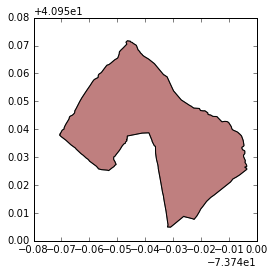

In [570]:
ss.plot()


In [33]:
ss_SHP=df_refSHP[df_refSHP['NAME'].str.contains('Scarsdale')]
#.iat[0,0]
#ss['geometry'].plot()
print ss_SHP['geometry']

106    POLYGON ((-73.81042500000001 40.98839299999999...
Name: geometry, dtype: object


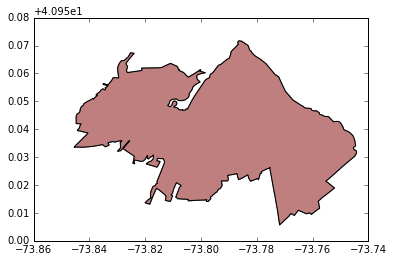

In [427]:
sz.plot()


In [230]:
from geopandas.tools import overlay

ImportError: No module named tools

# Pricing data; assigned to corresponding refshape

In [546]:
df_zillow_ny_regionData['refSHPindex']=assign_zRegion2RefSHP
df_zillow_ny_regionData[:3]

,ZIDM,ZTYPE,ZIDS,ZNAMES,ZLAT,ZLONG,ZPRICE,refSHPindex
0,6181,zipcode,62080,11368,40.752140,-73.853418,413100.0,299
1,6181,zipcode,62037,11226,40.647434,-73.958823,633400.0,299
2,6181,zipcode,62093,11385,40.698381,-73.887452,487800.0,299


In [119]:
# sanity check: zilow regions not mappable to schools (because sec-schools are omitted)
df_zillow_ny_regionData[df_zillow_ny_regionData['refSHPindex']==-1]

,ZIDM,ZTYPE,ZIDS,ZNAMES,ZLAT,ZLONG,ZPRICE,refSHPindex
434,27652,zipcode,62167,11580,40.676584,-73.704090,357100.0,-1
435,27652,zipcode,62168,11581,40.652618,-73.714628,405000.0,-1
436,27652,zipcode,62169,11582,40.662145,-73.702610,387700.0,-1
480,31419,zipcode,61978,11003,40.699356,-73.706137,336400.0,-1
511,46509,zipcode,62157,11566,40.646942,-73.551692,467500.0,-1
568,38598,zipcode,61981,11010,40.700168,-73.673972,410100.0,-1
675,13026,main,13026,North New Hyde Park,40.747676,-73.681893,582800.0,-1
684,24725,zipcode,61977,11002,40.726541,-73.708598,546600.0,-1
815,33074,zipcode,61992,11041,40.730200,-73.683699,520300.0,-1
817,33074,zipcode,61995,11044,40.734899,-73.688199,520300.0,-1


In [547]:
# combine data in the same refSHPindex using desired aggregator
df_price=df_zillow_ny_regionData[['refSHPindex','ZPRICE','ZLAT','ZLONG']].groupby('refSHPindex').mean()
df_price.rename(columns={'ZPRICE':'zprice'},inplace=True)
df_price[:5]

,zprice,ZLAT,ZLONG
refSHPindex,,,
-1,483518.750000,40.710043,-73.682292
0,637400.000000,40.844821,-73.643269
1,414700.000000,40.664910,-73.492348
2,411560.000000,40.712147,-73.596235
3,428033.333333,40.655916,-73.515338


# plot home prices on map

In [695]:
t1=pd.merge(df_refSHP,df_price,left_index=True,right_index=True,how='left')
df_price_shape = t1[['name','centroid','geometry','zprice']]

In [696]:
crs = crs = {'init': 'epsg:4326', 'no_defs': True}
geo_df = gpd.GeoDataFrame(df_price_shape, crs=crs)
geo_str = geo_df.to_json()

In [697]:
print geo_df['zprice'].describe()

count    5.310000e+02
mean     2.480405e+05
std      2.568224e+05
min      4.700000e+04
25%      1.084667e+05
50%      1.535000e+05
75%      2.792750e+05
max      2.632400e+06
Name: zprice, dtype: float64


In [699]:
# function to provide color (from colorbrewer)
def getColor(d):
    if d > 1000000: 
        return '#4d9221' # green
    elif d > 500000:
        return '#7fbc41'
    elif d > 400000:
        return '#b8e186'
    elif d > 300000:
        return '#e6f5d0'
    elif d > 200000:
        return '#fde0ef'
    elif d > 100000:
        return '#f7f7f7'
    elif d > 80000:
        return '#f1b6da'
    elif d > 60000:
        return '#de77ae'
    elif d > 40000:    
        return '#c51b7d'
    elif d > 20000: 
        return '#8e0152' # pink
    return '#d9d9d9'

In [700]:
#
m = folium.Map([40.6,-73.938], zoom_start=8,tiles='cartodbpositron')

folium.GeoJson(geo_df,    style_function=lambda feature: {
        'fillColor': getColor(feature['properties']['zprice']),
        'color' : 'black',
        'weight' : 1,
        'fillOpacity':1, 'opacity':0.2
        }
              ).add_to(m)
path='medHomePrice.html'
m.save(path)


# get baseline pricing based on lat-long (kneighbor)

In [678]:
# training set: data from 532 price,(zlat,zlong data)
t=df_price[df_price.index.values>-1]
X_train = t[['ZLONG','ZLAT']].as_matrix()
y_train=t['zprice'].tolist()

In [679]:
# applied to: 672 refshapes
X_test = [ list(x) for x in df_refSHP['centroid'].as_matrix() ]

In [680]:
from sklearn.neighbors import KNeighborsRegressor
kr = KNeighborsRegressor(n_neighbors=15)
kr.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='uniform')

In [681]:
price_baseline = kr.predict(X_test)

In [682]:
df_price_baseline = pd.DataFrame({'price_baseline':price_baseline},index =range(672))
df_price_baseline[:3]


,price_baseline
0,825475.555556
1,373469.555556
2,514428.444444


In [683]:
dill.dump(df_price_baseline,open('../OUTDATA/price_baseline.dill','wb'))

# Combining pricing data and feature(s) based on refshapes

In [540]:
print "price",len(df_price),df_price.index[:5]
print "school",len(df_schoolPerform),df_schoolPerform.index[:5]
print "crime",len(df_crime),df_crime.index[:5]
print "roi",len(df_roi),df_roi.index[:5]

price 532 Int64Index([-1, 0, 1, 2, 3], dtype='int64', name=u'refSHPindex')
school 641 Int64Index([0, 1, 2, 3, 4], dtype='int64', name=u'refshpindex')
crime 672 Int64Index([1, 2, 3, 8, 10], dtype='int64', name=u'refshpindex')
roi 534 Int64Index([0, 1, 2, 3, 5], dtype='int64', name=u'targetind')


In [537]:
df_crime = dill.load(open('../OUTDATA/refshape_crime2014.dill','rb'))
df_crime[df_crime.index.values==1]

,PD,county,crimerate_property,crimerate_total,crimerate_violent,geometry,name,refshpindex
refshpindex,,,,,,,,
1,Hempstead Vg PD,Nassau,0.127014,0.190324,0.06331,"POLYGON ((-73.50683099999999 40.666806, -73.50...",Seaford Union Free School District,1


In [623]:
df_roi=dill.load(open('../OUTDATA/refshape_roi_2006-2016.dill','rb'))
df_roi[:2]

,name,county,RegionID,Metro,roi,geometry
refshpindex,,,,,,
0,North Shore Central School District,Nassau,13747.0,New York,-0.134523,"POLYGON ((-73.67107299999999 40.859299, -73.65..."
1,Seaford Union Free School District,Nassau,33904.0,New York,-1.439441,"POLYGON ((-73.50683099999999 40.666806, -73.50..."


In [634]:
t1=pd.merge(df_price,df_schoolPerform,left_index=True,right_index=True,how='inner')
del t1['ZLAT']
del t1['ZLONG']
t2=pd.merge(t1,df_crime[['crimerate_total','crimerate_violent','crimerate_property']],left_index=True,right_index=True,how='inner')
t3=pd.merge(t2,df_roi[['roi']],left_index=True,right_index=True,how='inner')
t4=pd.merge(t3,df_price_baseline,left_index=True,right_index=True,how='inner')
t4[:10]
df_price_features=t4
df_price_features['premium'] = df_price_features['zprice']-df_price_features['price_baseline']
df_price_features[:3]

,zprice,sch_perform,crimerate_total,crimerate_violent,crimerate_property,roi,price_baseline,premium
0,637400.0,0.0,1.319789,0.152516,1.167273,-0.134523,772685.000000,-135285.000000
1,414700.0,10.0,0.190324,0.063310,0.127014,-1.439441,409826.666667,4873.333333
2,411560.0,0.0,0.190324,0.063310,0.127014,-1.869599,451332.000000,-39772.000000


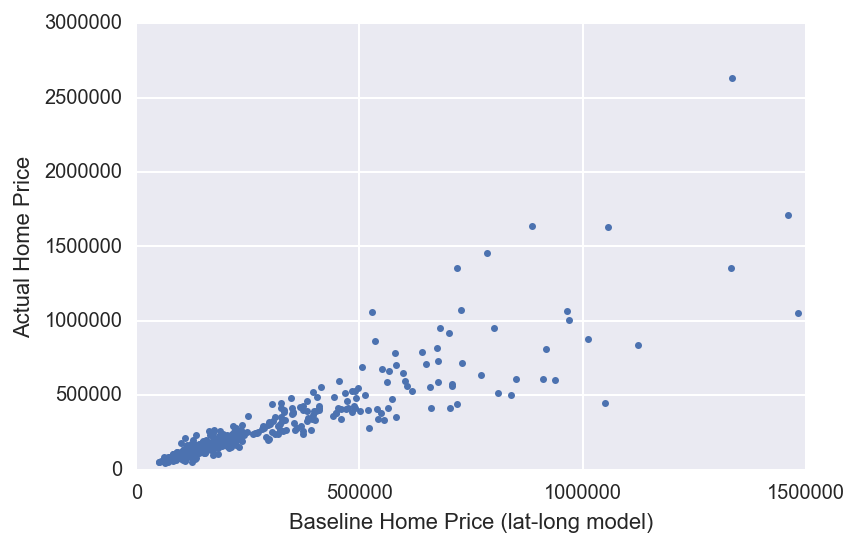

In [684]:
plt.plot(df_price_features['price_baseline'], df_price_features['zprice'], '.')
plt.locator_params(nbins=6)
plt.xlabel('Baseline Home Price (lat-long model)')
plt.ylabel('Actual Home Price')

# posting to postgresql

In [316]:
from sqlalchemy import create_engine
from sqlalchemy import types as sqt

In [319]:
# connecting to local using sqlachemy
local_engine_alchemy = create_engine('postgresql://enghuiy:@localhost:5432/nysRealEstate')

In [1111]:
# remote db (heroku-app: homevalue-hunter)

remote_engine = create_engine('postgresql://%s:%s@%s:5432/%s' %(USER,PGPASSWORD,HOST,DATABASE))
try:
    connection=remote_engine.connect()
except:
    print "I am unable to connect to the database"

#result = connection.execute("select * from price2features" )

I am unable to connect to the database


In [ ]:
df_price_features.to_sql('price2features', local_engine_alchemy, if_exists='replace',index_label='refshpindex')


In [499]:
# save to files

df_price_features.to_csv('../OUTDATA/price2features.csv')

# extracting from postgresql

In [362]:
import psycopg2
import urlparse


In [363]:
# connect to local database using psycopg2
try:
    connl = psycopg2.connect("dbname='nysRealEstate' user='enghuiy' host='localhost' password=''")
except:
    print "I am unable to connect to the database"
connl.set_session(autocommit=True);   
cur = connl.cursor()

In [338]:
# to use on heroku
url = urlparse.urlparse(url_)

conn = psycopg2.connect(
    database=url.path[1:],
    user=url.username,
    password=url.password,
    host=url.hostname,
    port=url.port,
#    sslmode='require'
)

NameError: name 'urlparse' is not defined

# Machine Learning 

In [636]:
import numpy as np
import re
import math

from sklearn import linear_model as lm
from sklearn.metrics import r2_score

In [67]:
# normalization
def norm(x_in,x_norm):
    
    x_mu = np.mean(x_in)
    x_range = np.amax(x_in) - np.amin(x_in)
    x_norm [:] = [ ( x - x_mu ) / float (x_range) for x in x_in]
    return (x_mu, x_range)

# convert back to abs value
def unnorm(x_mu, x_range, x_norm):
    x_out=[]
    x_out [:] = [ x*x_range+x_mu for x in x_norm ]
    return x_out

In [666]:
# extract data from dataframes
tmp=df_price_features.dropna()
print len(tmp)
#feature1=tmp['SCH_PERFORM'].tolist()
#homevalue=tmp['ZPRICE'].tolist()
tmp[:3]

457


,zprice,sch_perform,crimerate_total,crimerate_violent,crimerate_property,roi,price_baseline,premium
0,637400.0,0.0,1.319789,0.152516,1.167273,-0.134523,772685.000000,-135285.000000
1,414700.0,10.0,0.190324,0.063310,0.127014,-1.439441,409826.666667,4873.333333
2,411560.0,0.0,0.190324,0.063310,0.127014,-1.869599,451332.000000,-39772.000000


R^2 =  0.08


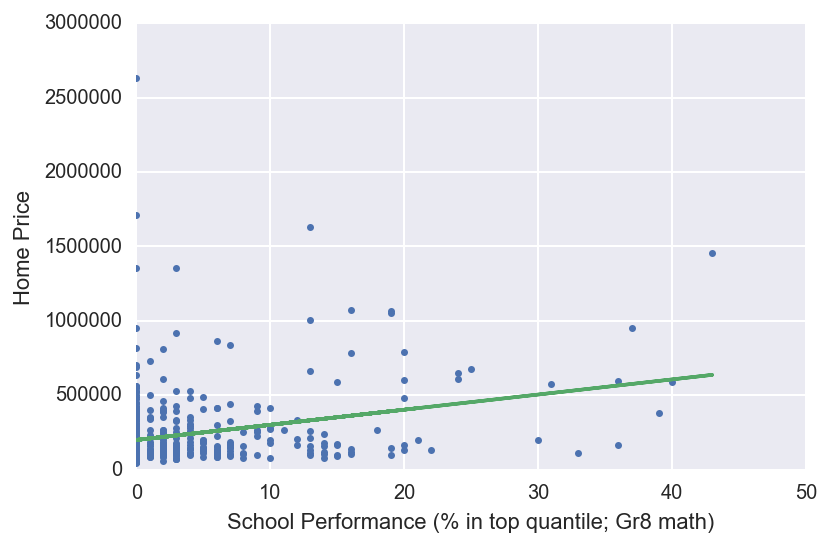

In [663]:
# univariate regression: school-performance; no baseline adjustment
X_train = np.asarray(tmp['sch_perform'].tolist()).reshape(len(tmp),1)
y_train = tmp['zprice'].tolist()

lm1 = lm.LinearRegression(normalize=True)
lm1.fit(X_train, y_train)
y_predict0 = lm1.predict(X_train)
score = lm1.score(X_train,y_train)

plt.plot(X_train, y_train, '.')
plt.plot(X_train, y_predict0)
plt.locator_params(nbins=6)
plt.xlabel('School Performance (% in top quantile; Gr8 math)')
plt.ylabel('Home Price')
print "R^2 = %5.2f" % score

#test_xy = df_price_features[['sch_perform','zprice']].dropna()
#X_test = np.asarray(test_xy['sch_perform'].tolist()).reshape(len(tmp),1)
#y_test = test_xy['zprice'].tolist()
#print len(y_test)

#y_predict = lm1.predict(y_test)


R^2 =  0.01


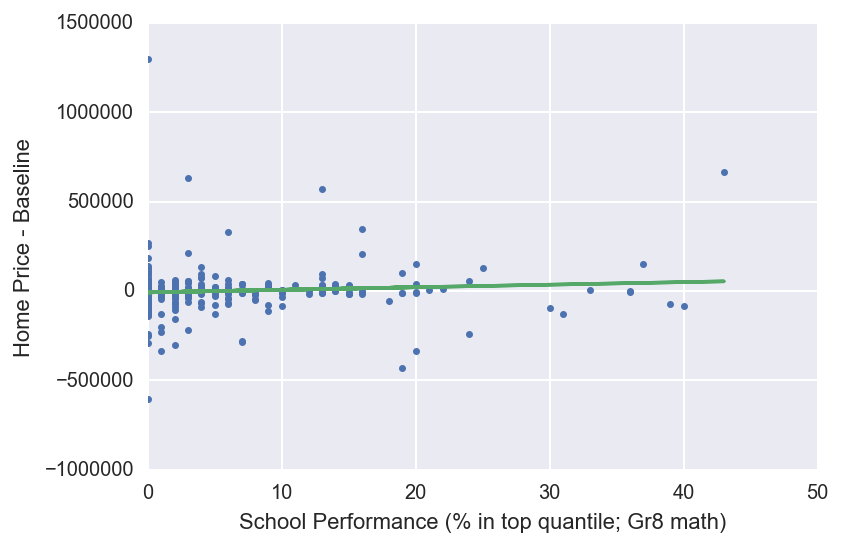

In [685]:
# univariate regression: school-performance; with baseline adjustment
X_train = np.asarray(tmp['sch_perform'].tolist()).reshape(len(tmp),1)
y_train = tmp['premium'].tolist()

lm1 = lm.LinearRegression(normalize=True)
lm1.fit(X_train, y_train)
y_predict0 = lm1.predict(X_train)
score = lm1.score(X_train,y_train)

plt.plot(X_train, y_train, '.')
plt.plot(X_train, y_predict0)
plt.locator_params(nbins=6)
plt.xlabel('School Performance (% in top quantile; Gr8 math)')
plt.ylabel('Home Price - Baseline')
print "R^2 = %5.2f" % score

#test_xy = df_price_features[['sch_perform','zprice']].dropna()
#X_test = np.asarray(test_xy['sch_perform'].tolist()).reshape(len(tmp),1)
#y_test = test_xy['zprice'].tolist()
#print len(y_test)

#y_predict = lm1.predict(y_test)


In [675]:
# multivariate regression: school,roi,crime; no baseline adjustment
X_train = np.asarray(tmp[['sch_perform','crimerate_total','roi']].as_matrix()).reshape(len(tmp),3)
y_train = tmp['zprice'].tolist()

lm3 = lm.LinearRegression(normalize=True)
lm3.fit(X_train, y_train)
y_predict0 = lm3.predict(X_train)
score = lm3.score(X_train,y_train)

#plt.plot(X_train, y_train, '.')
#plt.plot(X_train, y_predict0)
#plt.locator_params(nbins=6)
#plt.xlabel('School Performance (% in top quantile; Gr8 math)')
#plt.ylabel('Home Price')
print "R^2 = %5.2f" % score
print lm3.coef_


#test_xy = df_price_features[['sch_perform','zprice']].dropna()
#X_test = np.asarray(test_xy['sch_perform'].tolist()).reshape(len(tmp),1)
#y_test = test_xy['zprice'].tolist()
#print len(y_test)

#y_predict = lm1.predict(y_test)


R^2 =  0.13
[  8832.074619   -37106.50134606 -17246.89053421]


In [687]:
# univariate regression: school,crime,roi; with baseline adjustment
X_train = np.asarray(tmp[['sch_perform','crimerate_total','roi']].as_matrix()).reshape(len(tmp),3)
y_train = tmp['premium'].tolist()

lm3b = lm.LinearRegression(normalize=True)
lm3b.fit(X_train, y_train)
y_predict0 = lm3b.predict(X_train)
score = lm3b.score(X_train,y_train)

#plt.plot(X_train, y_train, '.')
#plt.plot(X_train, y_predict0)
#plt.locator_params(nbins=6)
#plt.xlabel('School Performance (% in top quantile; Gr8 math)')
#plt.ylabel('Home Price - Baseline')
print "R^2 = %5.2f" % score
print lm3b.coef_

#test_xy = df_price_features[['sch_perform','zprice']].dropna()
#X_test = np.asarray(test_xy['sch_perform'].tolist()).reshape(len(tmp),1)
#y_test = test_xy['zprice'].tolist()
#print len(y_test)

#y_predict = lm1.predict(y_test)


R^2 =  0.04
[  1464.86519525  -5589.04655566  10986.98265378]


In [69]:
# univariate regression (homePrice vs. SAT score)
x1_norm=[]; y_norm=[]
(x1_mu,x1_range) = norm(feature1,x1_norm)
(y_mu, y_range) = norm(homevalue, y_norm)

# univariate linear regression, with x0=1
#X_train = zip( np.ones(len(x1_norm)),x1_norm)

X_train = np.asarray(zip( np.ones(len(x1_norm)),x1_norm))
#X_train = zip(np.asarray(x1_norm).reshape(-1,1)



In [70]:
# Create linear regression object
regr = lm.LinearRegression()
regr.fit(X_train, y_norm)

# convert y back to abs value
y_predicted_norm1 = regr.predict(X_train)
y_predicted1 = unnorm(y_mu,y_range,y_predicted_norm1)

print r2_score(y_norm, y_predicted_norm1)


0.0921266199088


OperationalError: FATAL:  no pg_hba.conf entry for host "69.127.188.77", user "ofnhsnebpcurpl", database "daaricgfqmsolv", SSL off


In [661]:
cur = connl.cursor()
#command=SELECT 'ZPRICE' from price2features
#cur.execute("""SELECT version()""")
#cur.fetchone()
#cur.execute("""SELECT refSHP."NAME","ZPRICE","SCH_PERFORM" from price2features JOIN refshape ON  price2features."REFSHPINDEX"=refSHP."refSHPindex" WHERE "SCH_PERFORM" > 0;""")
#cur.execute("""SELECT "ZPRICE","SCH_PERFORM" from price2features;""")
#cur.execute("""SELECT "ZPRICE","SCORE" from price2features WHERE "SCORE" IS NOT NULL""")
#data=zip(*cur.fetchall())
#homevalue = list(data[0])
#features  = list(data[1])

In [1130]:
# normalization
def norm(x_in,x_norm):
    
    x_mu = np.mean(x_in)
    x_range = np.amax(x_in) - np.amin(x_in)
    x_norm [:] = [ ( x - x_mu ) / float (x_range) for x in x_in]
    return (x_mu, x_range)

# convert back to abs value
def unnorm(x_mu, x_range, x_norm):
    x_out=[]
    x_out [:] = [ x*x_range+x_mu for x in x_norm ]
    return x_out

# univariate regression
def linearRegression(features,homevalue):
    x_norm=[]; y_norm=[]
    (x_mu,x_range) = norm(features,x_norm)
    (y_mu, y_range) = norm(homevalue, y_norm)

    X_train = np.asarray(zip( np.ones(len(x_norm)),x_norm))

    # Create linear regression object
    regr = lm.LinearRegression()
    regr.fit(X_train, y_norm)
    # convert y back to abs value
    y_predicted_norm = regr.predict(X_train)
    coeffs = regr.coef_
    intercepts = regr.intercept_

    y_predicted = unnorm(y_mu,y_range,y_predicted_norm)

    r2=r2_score(y_norm, y_predicted_norm)
     
    return (coeffs,intercepts,r2,y_predicted)


In [1131]:
coeffs,intercepts,r2,ypredicted =  linearRegression(features,homevalue)
